In [1]:
# Imports (and even just starting the kernel)
# takes a while on SDF, due to the network filesystem.
# Sometimes the kernel does not (re)start at all.
print("Imports started")

from datetime import datetime
from functools import partial
import json
from pathlib import Path

import fastai.vision.all as fv
import numpy as np
from scipy import stats
import torch

import deepdarksub as dds

print("Imports done")

Imports started
Imports done


## Configuration

In [2]:
# Parameters to fit and shorthand names
mdef = 'main_deflector_parameters_'
fit_parameters, short_names = zip(*(
    (mdef + 'theta_E', 'theta_E'),
    ('subhalo_parameters_sigma_sub', 'sigma_sub'),
    ('los_parameters_delta_los', 'delta_los'),
    (mdef + 'center_x', 'center_x'),
    (mdef + 'center_y', 'center_y'),
    (mdef + 'gamma', 'gamma'),
    (mdef + 'gamma1', 'gamma1'),
    (mdef + 'gamma2', 'gamma2'),
    (mdef + 'e1', 'e1'),
    (mdef + 'e2', 'e2')))

# Configuration
train_config = dict(
    dataset_name = 'more_500k',
    fit_parameters = fit_parameters,
    uncertainty = 'diagonal',
    augment_rotation = 'free',
    batch_size = 1024,

    # Sigma_sub is our inference goal, but quite hard in the beginning.
    # theta_E is very correlated, and gamma slightly correlated.
    parameter_weights={
        'subhalo_parameters_sigma_sub': 10,
        mdef + 'theta_E': 10,
        mdef + 'gamma': 5},
    
    n_epochs = 200,
    architecture = 'resnet18',
    bn_final = True,
    base_lr = 0.05)

# Get a unique name from the current time and configuration,
# for naming the model and training logs,
result_name = (
    datetime.now().strftime('%y%m%d_%H%M') 
    + '_' + train_config['dataset_name']
    + '_' + dds.deterministic_hash(train_config))
print(result_name)

210622_2127_more_500k_jqw5uxkpqm


## Load data

In [3]:
data_dir = Path('/lscratch/jaalbers') / train_config['dataset_name']
if not data_dir.exists():
    print(f"Extracting training data to {data_dir} (will take a minute or so)")
    !7z x /scratch/jaalbers/{train_config['dataset_name']}.zip -o/lscratch/jaalbers > /dev/null

# Load metadata
meta, galaxy_indices = dds.load_metadata(data_dir, remove_bad=True)

normalizer = dds.Normalizer(meta, train_config['fit_parameters'])

2335 distinct source galaxies used by manada. 
Throw away 110, use 99 for validation, 2163 left for training.

Total images: 484186; 463024 for training and 21162 for validation.


In [4]:
print("Training on " + torch.cuda.get_device_name(torch.cuda.current_device()))
assert torch.cuda.is_available()

# Setting these up will take a while
data_block = dds.data_block(
    meta, train_config['fit_parameters'], data_dir, train_config['uncertainty'], 
    augment_rotation=train_config['augment_rotation'])
data_loaders = data_block.dataloaders(None, bs=train_config['batch_size'])

Training on NVIDIA GeForce RTX 2080 Ti


## Setup training metrics and network

In [5]:
n_params = len(train_config['fit_parameters'])

assert train_config['uncertainty'] == 'diagonal'
metrics = dds.all_metrics(fit_parameters, normalizer, short_names)

learner = fv.cnn_learner(
    dls=data_loaders,
    arch=getattr(fv, train_config['architecture']),
    n_in=1,
    n_out=dds.n_out(n_params, train_config['uncertainty']),
    loss_func=dds.loss_for(
        fit_parameters, 
        train_config['uncertainty'],
        parameter_weights=train_config.get('parameter_weights')),
    metrics=metrics,
    pretrained=False,
    bn_final=train_config['bn_final'])

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.25118863582611084)

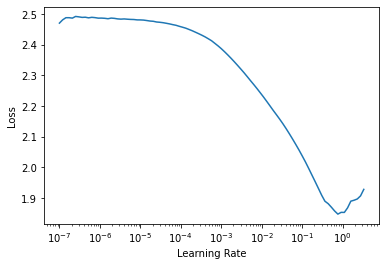

In [6]:
learner.lr_find()

## Training

In [ ]:
learner.fit_one_cycle(
    n_epoch=train_config['n_epochs'],
    lr_max=train_config['base_lr'])

epoch,train_loss,valid_loss,theta_E_rmse,sigma_sub_rmse,delta_los_rmse,center_x_rmse,center_y_rmse,gamma_rmse,gamma1_rmse,gamma2_rmse,e1_rmse,e2_rmse,theta_E_unc,sigma_sub_unc,delta_los_unc,center_x_unc,center_y_unc,gamma_unc,gamma1_unc,gamma2_unc,e1_unc,e2_unc,theta_E_rho,sigma_sub_rho,delta_los_rho,center_x_rho,center_y_rho,gamma_rho,gamma1_rho,gamma2_rho,e1_rho,e2_rho,theta_E_sigma_su/b_rho,sigma_sub_sigma_su/b_rho,delta_los_sigma_su/b_rho,center_x_sigma_su/b_rho,center_y_sigma_su/b_rho,gamma_sigma_su/b_rho,gamma1_sigma_su/b_rho,gamma2_sigma_su/b_rho,e1_sigma_su/b_rho,e2_sigma_su/b_rho,time
0,1.105062,1.038803,3.785905,0.889514,0.890669,0.310695,0.321655,0.985214,0.098702,0.104752,0.103292,0.104124,1.655146,1.083391,1.086150,0.285478,0.285052,1.180913,0.089209,0.089663,0.088925,0.089447,0.967641,0.069289,-0.011983,0.127221,0.099846,0.244996,0.023883,0.047278,0.008390,0.009777,0.395762,0.069289,0.003287,-0.014008,-0.014494,-0.034906,-0.018848,-0.002441,-0.004986,-0.003597,02:50
1,0.901679,inf,0.944981,0.029504,0.138404,0.002718,0.002933,0.082669,0.001121,0.001200,0.005419,0.005571,2.103228,1.080269,1.081901,0.294414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.676694,0.010358,-0.000058,0.001625,-0.007298,0.006849,-0.044455,0.019283,0.010891,0.000737,0.106451,0.010358,0.000120,-0.000166,-0.008524,-0.018239,-0.043727,-0.018599,-0.010856,-0.000443,02:51


/sdf/home/j/jaalbers/software/deepdarksub/deepdarksub/normalize.py:75: RuntimeWarning: overflow encountered in power
  x_unc = np.stack([2 ** x[:, n_params + i] * self.scales[p]


## Save results

In [ ]:
result_dir = Path('training_results')
result_dir.mkdir(exist_ok=True)

out = dict(zip(
    ['train_loss', 'val_loss', *[f.name for f in metrics]], 
    np.stack(learner.recorder.values).T.tolist()))
out.update(
    train_loss_hr = [x.numpy().item() 
                     for x in learner.recorder.losses],
    # only last epoch duration is recorded... oh well
    epoch_duration = learner.recorder.log[-1],
    n_images = len(meta),
    train_config=train_config)

with open(result_dir / (result_name + '.json'), mode='w') as f:
    json.dump(out, f)
    
learner.save(result_name)

## Quick evaluation

In [ ]:
# **This destroys learn.recorder!** Make sure you do not run save again!
preds, targets = learner.get_preds(ds_idx=1, reorder=False)
y_pred, y_unc = normalizer.decode(preds, uncertainty=train_config['uncertainty'], as_dict=True)
y_true, _ = normalizer.decode(targets[:,:n_params], as_dict=True)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_pred[mdef + 'theta_E'],
            y_pred['subhalo_parameters_sigma_sub'], 
            marker='.', edgecolor='none', s=2,)
plt.xlabel(r"$\theta_E$")
plt.ylabel(r"$\Sigma_\mathrm{sub}$")
plt.xlim(0.75, 1.6)
plt.ylim(0, 0.2)
plt.savefig(result_name + '_qe_ssub.png', dpi=200, bbox_inches='tight')

 * 210620_1504_more_500k_ziqxgbt4on: First with new metrics, incorrect definition of rmse ratio
 * 210620_1718_more_500k_ziqxgbt4on: Corrected metrics (1/ratio)
 * 210620_1833_more_500k_ziqxgbt4on: Weighting code added, no weights changed (null test)
 * 210620_1943_more_500k_4bt4ngpzzu: 5x weight for sigma_sub. LR find shows a bit of a turn-up after 1.0; should still be safe around 0.1, right? Anyway, no big change.
 * 210620_2017_more_500k_tdsqjb47r3: 50x weight for sigma_sub. No upturn in LR curve anymore, looks just like one for 1x weight. (maybe it was just random effects?). Still no big change.
 * **210620_2310_more_500k_qo2e5nqumx: 100 epochs, no weighting.**
 * 210621_2216_more_500k_gnpefbkojl: 10x weight for sigma_sub, 10 theta_e, 5x gamma.
 * 210621_2237_more_500k_pqh44utj5w: 200 epochs with 10-10-5 weighting. Crashed after epoch 23 (I closed notebook after 15, so we will never know what happened...)
 * **210622_2127_more_500k_jqw5uxkpqm**: 200 epochs, 10-10-5 weighting, cut learning rate in half (0.05)
 